In [1]:

# !pip install nltk #to remove stopwords

import re
import time

import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nlp = spacy.load('en_core_web_sm')  # Loading spacy English
import matplotlib.pyplot as plt

from gensim import corpora
from gensim.models import Nmf
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import warnings

warnings.filterwarnings('ignore', module='pandas')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#loading the data file: it is also available via below link:
# 'https://www.kaggle.com/datasets/khalidryder777/500k-chatgpt-tweets-jan-mar-2023'

data = pd.read_csv('/Users/busracaliskan/Desktop/Thesis Data/Twitter Jan Mar.csv')


In [3]:
data.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0


In [4]:
#creating a copy of dataset
df = data.copy()

In [5]:
#dropping the rows that contain NA values
df_dropped = df.dropna()
df_dropped.shape

(499974, 6)

In [6]:

# To check for duplicate values in the "content" column
duplicates = df_dropped.duplicated(subset='content')

# Print the duplicate rows
#print(df[duplicates])

# Remove the duplicate rows
df_unique = df_dropped.drop_duplicates(subset='content')

# Print the DataFrame without duplicates
print(df_unique.shape)


(493705, 6)


In [7]:
# Calculating the word lengths for each tweet
doc_lens = [len(tweet.split()) for tweet in df_unique['content']]

# Calculating the average tweet word length
avg_length = np.mean(doc_lens)
print(avg_length)




24.599704276845486


In [8]:
#i decided to analyse top 30000 retweeted tweets since its a huge dataset so hard to analyse and 
#its more valuable to work with most influential tweets.

sorted_df = df_unique.sort_values(by='retweet_count', ascending=False)

# Reset the index from the beginning
sorted_df.reset_index(drop=True, inplace=True)
sorted_df

,date,id,content,username,like_count,retweet_count
0,2023-01-13 04:30:44+00:00,1613755402608381952,Best AI Tools You Need To Know\n#chatgpt #chat...,johnvianny,63835.0,16080.0
1,2023-01-07 04:31:47+00:00,1611581338351730688,ultra-modern generative ai🗨️: \n\n• AI2\n• AI2...,aaronsiim,42125.0,11501.0
2,2023-01-09 04:35:00+00:00,1612306922681630721,"Creators and writers are making $1,000,000s us...",garryflix,13393.0,8096.0
3,2023-03-25 04:31:39+00:00,1639485169911627777,$150 || 7250 PHP || 2.1 IDR\n\n$100\n✅ RT &amp...,crypto_bearr,1833.0,8060.0
4,2023-02-24 13:49:22+00:00,1629116276286029824,$250 — 48 Hours — \n\n➖ RT &amp; Follow: @Dege...,TheRavenCrypto,1705.0,5429.0
...,...,...,...,...,...,...
493700,2023-03-02 12:12:47+00:00,1631266299392274438,TechScape: Seven top AI acronyms explained - T...,PDH_Metaverse,0.0,0.0
493701,2023-03-02 12:12:49+00:00,1631266307277504515,AI Copywriting And SEO: Is It Worth It? - Forb...,PDH_Metaverse,2.0,0.0
493702,2023-03-02 12:12:50+00:00,1631266309722763264,What Does AI Have to do With Digital Assets an...,PDH_Metaverse,1.0,0.0
493703,2023-03-02 12:12:54+00:00,1631266325971468288,Elon Musk: 'AI stresses me out' - TechCentral ...,PDH_Metaverse,0.0,0.0


In [9]:
new_df = sorted_df.head(30000)

In [10]:
new_df.shape

(30000, 6)

In [11]:
new_df

,date,id,content,username,like_count,retweet_count
0,2023-01-13 04:30:44+00:00,1613755402608381952,Best AI Tools You Need To Know\n#chatgpt #chat...,johnvianny,63835.0,16080.0
1,2023-01-07 04:31:47+00:00,1611581338351730688,ultra-modern generative ai🗨️: \n\n• AI2\n• AI2...,aaronsiim,42125.0,11501.0
2,2023-01-09 04:35:00+00:00,1612306922681630721,"Creators and writers are making $1,000,000s us...",garryflix,13393.0,8096.0
3,2023-03-25 04:31:39+00:00,1639485169911627777,$150 || 7250 PHP || 2.1 IDR\n\n$100\n✅ RT &amp...,crypto_bearr,1833.0,8060.0
4,2023-02-24 13:49:22+00:00,1629116276286029824,$250 — 48 Hours — \n\n➖ RT &amp; Follow: @Dege...,TheRavenCrypto,1705.0,5429.0
...,...,...,...,...,...,...
29995,2023-03-28 09:13:39+00:00,1640643301899476992,This morning we shared ways to help #Teachers ...,scottdhayden,15.0,2.0
29996,2023-02-18 04:51:16+00:00,1626806533811232770,Bolster Your Job Search Endeavors Via Generati...,richardkimphd,1.0,2.0
29997,2023-03-07 18:15:56+00:00,1633169626241564672,@DavidToovey @MeteoRwanda The highest temperat...,AubinRukera,11.0,2.0
29998,2023-01-30 15:10:00+00:00,1620076871219044353,"Check out our new Teaching and Learning Guide,...",TLTatTWU,4.0,2.0


In [12]:
new_df.iloc[29997, 2]


'@DavidToovey @MeteoRwanda The highest temperature ever recorded in Rwanda was 35.7°C (96.3°F) in the capital city of Kigali on February 22, 2021. This temperature was recorded at the Kigali International Airport weather station. #ChatGPT'

# Preprocessing 

In [13]:
# same preprocessing technique with LDA is used for NMF


In [14]:
#to lowercase all the content
new_df.loc[:, 'content'] = new_df['content'].str.lower()


In [15]:
#new_df.iloc[23,2]

In [16]:
#removing hashtags, since they are already analysed

new_df.loc[:, 'content'] = new_df['content'].apply(lambda x: re.sub(r'#\w+', '', x))


In [17]:
#new_df.iloc[23,2]

In [18]:
#removing mentions

new_df.loc[:, 'content'] = new_df['content'].apply(lambda x: re.sub(r"@\w+", "", x))

In [19]:
#new_df.iloc[29997,2]

In [20]:
## removing URLs and HTTPs 

# Define the URL pattern using regular expressions
url_pattern = r"http[s]?:\/\/\S+"

# Apply the regex pattern to the 'content' column and replace URLs with an empty string
new_df.loc[:, 'content'] = new_df['content'].str.replace(url_pattern, "", regex=True)


In [21]:
#new_df.iloc[23,2]

In [22]:
# Remove punctuation from the 'content' column 

# Define a function to remove punctuation
def remove_punctuation(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text


# Apply the function to the 'content' column
new_df.loc[:, 'content'] = new_df['content'].apply(remove_punctuation)

In [23]:
#new_df.iloc[29997,2]

In [24]:
#removing numbers from the content

new_df.loc[:, 'content'] = new_df['content'].str.replace('\d+', '', regex=True)

#new_df.iloc[23,2] #to check if the numbers are removed.


In [25]:
# Remove emojis from text
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emojis
                               u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Apply emoji removal to the 'content' column
new_df['content'] = new_df['content'].apply(remove_emojis)

/var/folders/sn/rhc8g5z95vx7zq5bfg6h17800000gn/T/ipykernel_44794/1396063304.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['content'] = new_df['content'].apply(remove_emojis)


In [26]:
#new_df.iloc[23,2]

In [27]:
# Tokenize the 'content' column, remove stopwords, and single-letter tokens
stop_words = set(stopwords.words('english'))

new_df.loc[:, 'content'] = new_df['content'].apply(
    lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words and len(word) > 1]))


In [28]:
# finding compound words
def find_compound_words(text):
    doc = nlp(text)
    compound_words = []
    for token in doc:
        if token.dep_ == 'compound':
            compound_words.append(token.text)
    return compound_words


# Apply the function to the 'content' column
new_df.loc[:, 'compound_words'] = new_df.loc[:, 'content'].apply(find_compound_words)



/var/folders/sn/rhc8g5z95vx7zq5bfg6h17800000gn/T/ipykernel_44794/1144093375.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:,'compound_words'] = new_df.loc[:, 'content'].apply(find_compound_words)


In [29]:
new_df.iloc[23, 2]

'scrape web limited knowledge world introducing webchatgpt mighty chrome extension augments prompts relevant results web see demo video install'

In [30]:
new_df.iloc[23, 6]  #to see compounded words

['knowledge', 'chrome', 'extension', 'results', 'demo', 'video']

In [31]:
# Combine preprocessed 'content' and 'compound_words' columns
new_df['combined_text'] = new_df['content'] + new_df['compound_words'].apply(lambda x: ' '.join(x))

/var/folders/sn/rhc8g5z95vx7zq5bfg6h17800000gn/T/ipykernel_44794/3088102435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['combined_text'] = new_df['content'] + new_df['compound_words'].apply(lambda x: ' '.join(x))


In [32]:
# Function to replace tokens with lemmas
def replace_with_lemmas(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)


# Apply the function to the 'content' column
new_df['combined_text'] = new_df['combined_text'].apply(replace_with_lemmas)


/var/folders/sn/rhc8g5z95vx7zq5bfg6h17800000gn/T/ipykernel_44794/2846295210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['combined_text'] = new_df['combined_text'].apply(replace_with_lemmas)


In [33]:
#new_df.head

In [34]:
# Removing specific words and their variations from the 'combined_text' column
new_df['combined_text'] = new_df['combined_text'].apply(
    lambda x: re.sub(r'\b(chatgpt|chat gpt|gpt|amp|m|I|s)\b', '', x))



/var/folders/sn/rhc8g5z95vx7zq5bfg6h17800000gn/T/ipykernel_44794/21630410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['combined_text'] = new_df['combined_text'].apply(lambda x: re.sub(r'\b(chatgpt|chat gpt|gpt|amp|m|I|s)\b', '', x))


# NMF (non- negative matrix factorization)

In [35]:
# creating a copy of dataset to use NMF
df_nmf = new_df.copy()

In [36]:
df_nmf

,date,id,content,username,like_count,retweet_count,compound_words,combined_text
0,2023-01-13 04:30:44+00:00,1613755402608381952,best ai tools need know,johnvianny,63835.0,16080.0,[],good ai tool need know
1,2023-01-07 04:31:47+00:00,1611581338351730688,ultramodern generative ai ai ai mdm gptj gpt x...,aaronsiim,42125.0,11501.0,"[mdm, gptj, gpt, xclip, gopher, jukebox, anthr...",ultramodern generative ai ai ai mdm gptj xcli...
2,2023-01-09 04:35:00+00:00,1612306922681630721,creators writers making using chatgpt people d...,garryflix,13393.0,8096.0,"[creators, chatgpt, build, chatgpt, business, ...",creator writer make use people do not know bu...
3,2023-03-25 04:31:39+00:00,1639485169911627777,php idr rt amp follow join telegram post proof...,crypto_bearr,1833.0,8060.0,"[php, idr, rt, amp, follow, join, telegram, po...",php idr rt follow join telegram post proof en...
4,2023-02-24 13:49:22+00:00,1629116276286029824,hours rt amp follow join telegram generate ima...,TheRavenCrypto,1705.0,5429.0,"[rt, amp, follow, join, telegram, bot, post, t...",hour rt follow join telegram generate image u...
...,...,...,...,...,...,...,...,...
29995,2023-03-28 09:13:39+00:00,1640643301899476992,morning shared ways help using teacher briefin...,scottdhayden,15.0,2.0,"[ways, teacher, focus]",morning share way help use teacher briefing co...
29996,2023-02-18 04:51:16+00:00,1626806533811232770,bolster job search endeavors via generative,richardkimphd,1.0,2.0,"[job, search]",bolster job search endeavor via generativejob ...
29997,2023-03-07 18:15:56+00:00,1633169626241564672,highest temperature ever recorded rwanda capit...,AubinRukera,11.0,2.0,"[rwanda, capital, city, kigali, february, airp...",high temperature ever record rwanda capital ci...
29998,2023-01-30 15:10:00+00:00,1620076871219044353,check new teaching learning guide creating ass...,TLTatTWU,4.0,2.0,"[teaching, learning, assignments, outsmart, te...",check new teaching learning guide create assig...


In [37]:
# Create Dictionary

df_nmf["lemmatized_split"] = df_nmf["combined_text"].map(lambda x: x.split())
tokenized_docs = df_nmf["lemmatized_split"].tolist()
id2word = corpora.Dictionary(tokenized_docs)

# Creating corpus

corpus_nmf = [id2word.doc2bow(doc) for doc in df_nmf["lemmatized_split"].tolist()]

# Join the lemmatized split tokens into strings
df_nmf["lemmatized_string"] = df_nmf["lemmatized_split"].apply(lambda x: " ".join(x))

# Create the TfIdf vectorizer using sklearn
tfidf_vectorizer = TfidfVectorizer()

# Apply the TfIdf transformation
tfidf_matrix = tfidf_vectorizer.fit_transform(df_nmf["lemmatized_string"])

# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names()



/Users/busracaliskan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
# Calculate the dimensions of the input matrix
num_documents = tfidf_matrix.shape[0]
vocabulary_size = tfidf_matrix.shape[1]
print("Number of Documents:", num_documents)
print("Vocabulary Size:", vocabulary_size)


Number of Documents: 30000
Vocabulary Size: 45609


### estimating optimal nbr of topic for NMF

In [39]:
# Define the range of topic numbers to explore
num_topics = list(range(2, 16))

coherence_scores = []

# Iterate through the topic numbers
for num in num_topics:
    # Fit the NMF model
    nmf_model = Nmf(corpus=corpus_nmf, num_topics=num, id2word=id2word, random_state=42)

    # Calculate the coherence score for the current topic number
    coherence_model = CoherenceModel(model=nmf_model, texts=df_nmf["lemmatized_split"].tolist(), corpus=corpus_nmf,
                                     coherence="c_v")
    coherence_score = coherence_model.get_coherence()

    coherence_scores.append(coherence_score)

# Print the coherence scores for different topic numbers
for num, score in zip(num_topics, coherence_scores):
    print(f"Topic Number: {num}, Coherence Score: {score}")


Topic Number: 2, Coherence Score: 0.18125629782043268
Topic Number: 3, Coherence Score: 0.2647965414791405
Topic Number: 4, Coherence Score: 0.32696977682195316
Topic Number: 5, Coherence Score: 0.3381580650840249
Topic Number: 6, Coherence Score: 0.3492783616043236
Topic Number: 7, Coherence Score: 0.3370805561785534
Topic Number: 8, Coherence Score: 0.3748493927276595
Topic Number: 9, Coherence Score: 0.3644204070467447
Topic Number: 10, Coherence Score: 0.40747496898598745
Topic Number: 11, Coherence Score: 0.3697174559338036
Topic Number: 12, Coherence Score: 0.3627604965464774
Topic Number: 13, Coherence Score: 0.3878865346417731
Topic Number: 14, Coherence Score: 0.37845164834422546
Topic Number: 15, Coherence Score: 0.37837289010440084


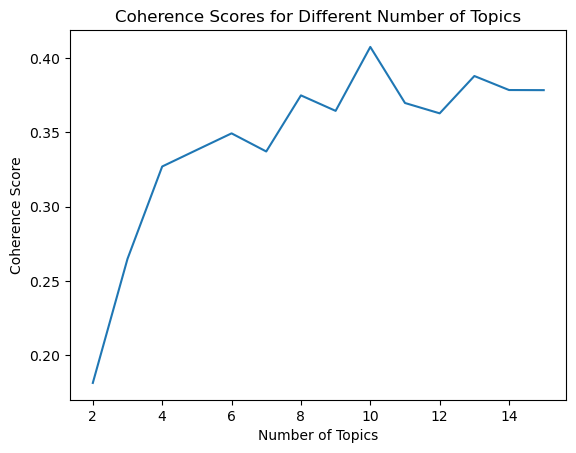

In [40]:
# Plot the coherence scores to see optimal one visuallt
plt.plot(num_topics, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Number of Topics")
plt.show()

In [41]:


# Define the number of topics which found in previous step
num_topics = 10

# Start the timer
start_time = time.time()

# Create the NMF model
nmf_model = NMF(n_components=num_topics, random_state=42)

# Fit the model to the TfIdf matrix
nmf_model.fit(tfidf_matrix)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed time:", elapsed_time, "seconds")

/Users/busracaliskan/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Elapsed time: 4.945392847061157 seconds


/Users/busracaliskan/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [42]:
# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names()

# Get the top 10 words for each topic
num_words = 10
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_indices = topic.argsort()[:-num_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")



Topic 1: ai tool generative open future good art world technology need
Topic 2: acquisition pay available interest free instalmentsacquisition coincidentally via cybersafecloudcom theremotejobscom
Topic 3: use case create way student code prompt learn tool content
Topic 4: not do get make work go job way take well
Topic 5: new search google microsoft bing chatbot engine launch power chat
Topic 6: like look design custom want order humanlikerobotsorder tool anyone rt
Topic 7: write ask poem question answer code think give well article
Topic 8: know need even everything good what answer whatschat here want
Topic 9: intelligence artificial future human technology world phase chatbot openai assist
Topic 10: language model large openai text api train generate release natural


/Users/busracaliskan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
# Get the topic distribution for each document
topic_distribution = nmf_model.transform(tfidf_matrix)

# Get the words with the highest values for each topic
num_words = 10  # Number of top words to display for each topic

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_indices = topic.argsort()[:-num_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    top_values = [topic[i] for i in top_words_indices]

    print(f"For topic {topic_idx + 1}, the words with the highest value are:")
    for word, value in zip(top_words, top_values):
        print(f"{word:10s} {value:.6f}")


For topic 1, the words with the highest value are:
ai         4.342749
tool       1.194531
generative 0.600831
open       0.214009
future     0.206735
good       0.182016
art        0.169641
world      0.168753
technology 0.167575
need       0.164645
For topic 2, the words with the highest value are:
acquisition 1.392847
pay        1.348518
available  1.271005
interest   1.214634
free       1.182068
instalmentsacquisition 1.081704
coincidentally 0.656006
via        0.492897
cybersafecloudcom 0.297502
theremotejobscom 0.205316
For topic 3, the words with the highest value are:
use        2.628904
case       0.255178
create     0.247974
way        0.209199
student    0.208836
code       0.174103
prompt     0.173454
learn      0.149845
tool       0.148519
content    0.145029
For topic 4, the words with the highest value are:
not        1.640797
do         1.169042
get        0.769235
make       0.611995
work       0.459947
go         0.456359
job        0.444827
way        0.434713
take  

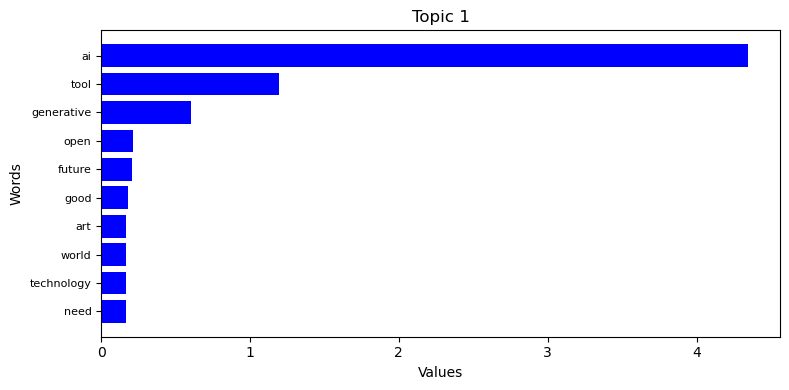

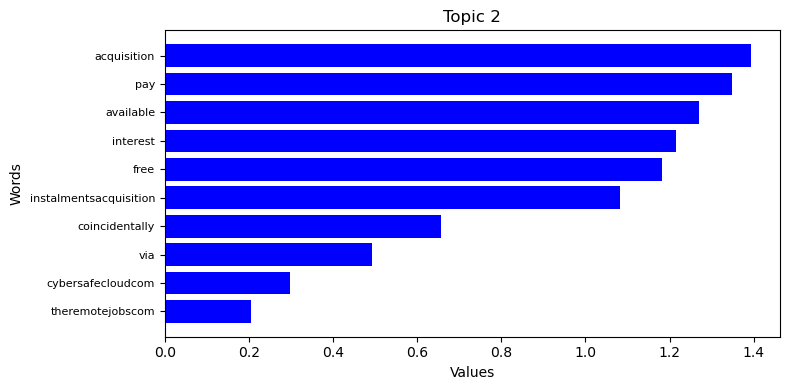

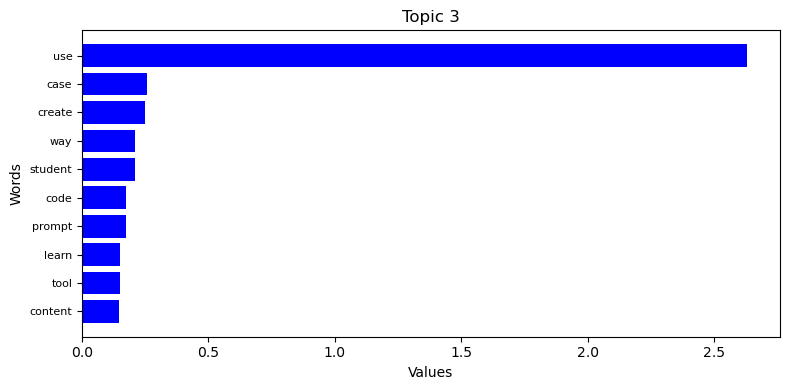

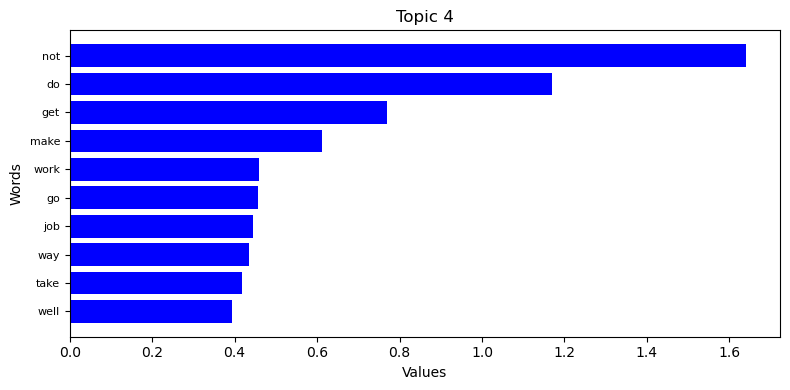

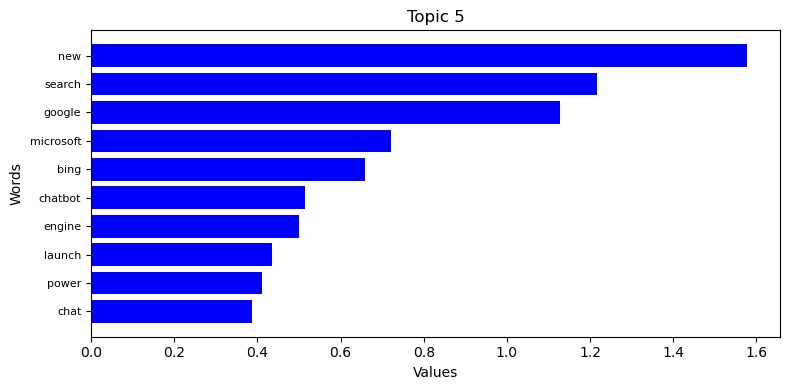

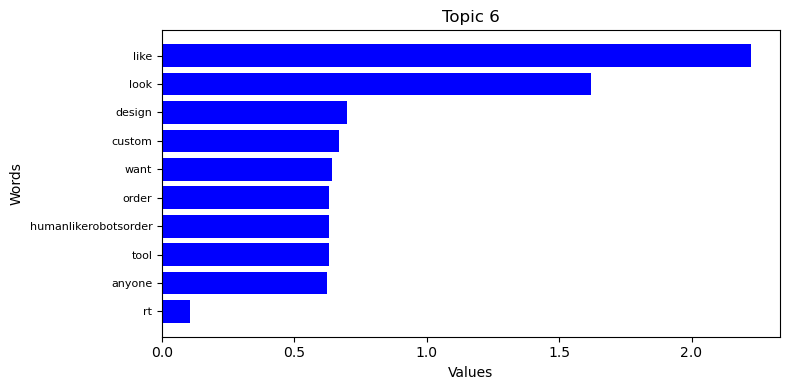

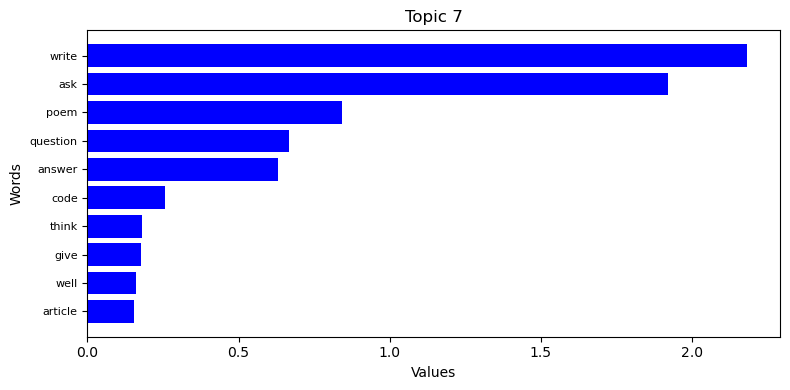

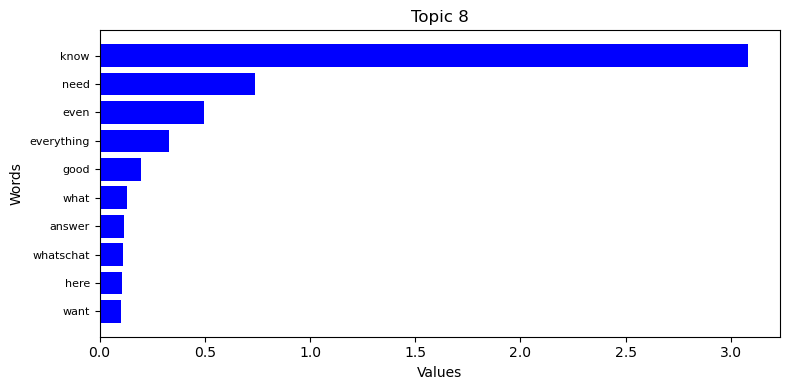

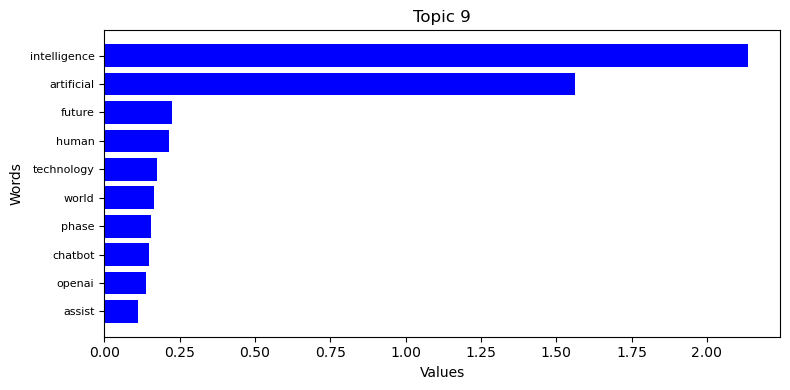

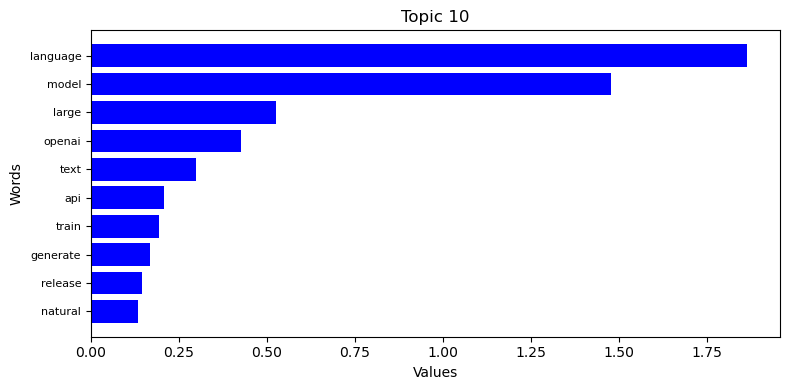

In [44]:
# Define the topic labels
topic_labels = [
    "Topic 1",
    "Topic 2",
    "Topic 3",
    "Topic 4",
    "Topic 5",
    "Topic 6",
    "Topic 7",
    "Topic 8",
    "Topic 9",
    "Topic 10"
]

# Get the topic distribution for each document
topic_distribution = nmf_model.transform(tfidf_matrix)

# Get the words with the highest values for each topic
num_words = 10  # Number of top words to display for each topic

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_indices = topic.argsort()[:-num_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    top_values = [topic[i] for i in top_words_indices]

    # Plot the words with their values
    plt.figure(figsize=(8, 4))
    plt.barh(np.arange(len(top_words)), top_values, color='blue')
    plt.yticks(np.arange(len(top_words)), top_words, fontsize=8)
    plt.xlabel('Values', fontsize=10)
    plt.ylabel('Words', fontsize=10)
    plt.title(topic_labels[topic_idx], fontsize=12)  # Set the topic label
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
